## Objetivo

Predecir el cultivo óptimo a sembrar en función de las mediciones del suelo (Nitrógeno, Fósforo, Potasio, pH), usando modelos de clasificación multiclase.


## Importamos librerias


In [5]:
#Importamos librerias
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import PowerTransformer
from catboost import CatBoostClassifier

## Analisis Exploratorio de datos

In [6]:
# Visualisamos el dataframe
data = pd.read_csv('datasets/soil_measures.csv')

data.head()

,N,P,K,ph,crop
0,90,42,43,6.502985,rice
1,85,58,41,7.038096,rice
2,60,55,44,7.840207,rice
3,74,35,40,6.980401,rice
4,78,42,42,7.628473,rice


In [7]:
# Verificamos el tamaño del dataframe, asi como la existencia de valores nulos o duplicados
print('Informacion de los datos\n')
display(data.info())
print('\nDescripcion de los datos\n')
display(data.describe())
print('\nValores nulos\n')
display(data.isnull().sum())
print('\nValores duplicados\n')
display(data.duplicated().sum())

Informacion de los datos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   N       2200 non-null   int64  
 1   P       2200 non-null   int64  
 2   K       2200 non-null   int64  
 3   ph      2200 non-null   float64
 4   crop    2200 non-null   object 
dtypes: float64(1), int64(3), object(1)
memory usage: 86.1+ KB


None


Descripcion de los datos



,N,P,K,ph
count,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,6.469480
std,36.917334,32.985883,50.647931,0.773938
min,0.000000,5.000000,5.000000,3.504752
25%,21.000000,28.000000,20.000000,5.971693
50%,37.000000,51.000000,32.000000,6.425045
75%,84.250000,68.000000,49.000000,6.923643
max,140.000000,145.000000,205.000000,9.935091



Valores nulos



N       0
P       0
K       0
ph      0
crop    0
dtype: int64


Valores duplicados



0

No hay valores nulos ni duplicados, lo que permite trabajar directamente sin limpieza.

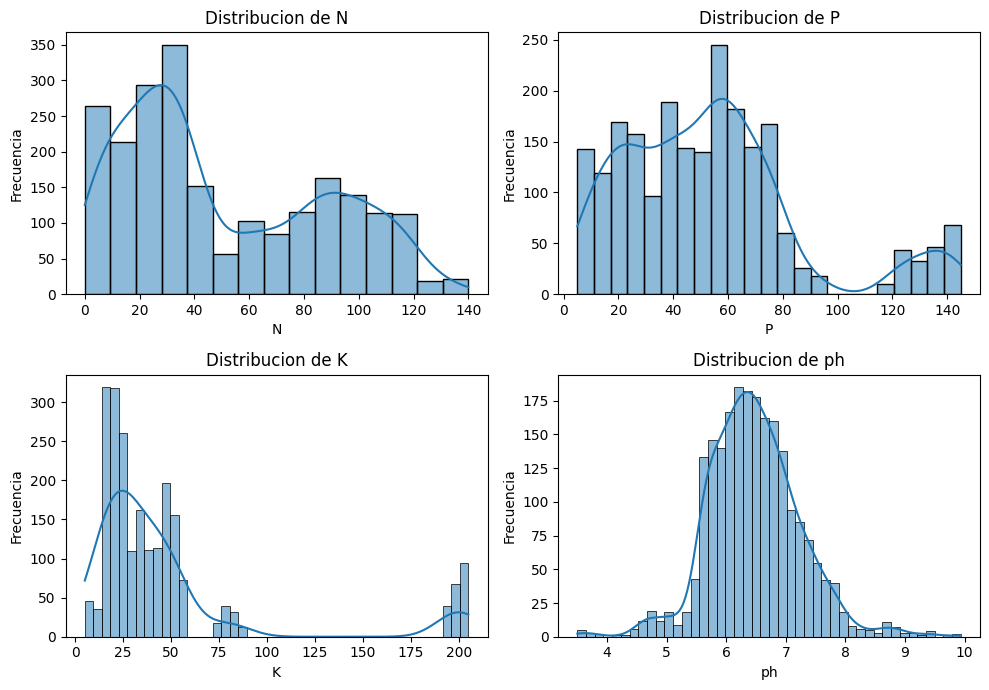

In [8]:
#Visualizamos distribucion de valores predictores
data_graf = data[['N', 'P', 'K', 'ph']]
fig, axes = plt.subplots(2, 2, figsize=(10, 7))
axes = axes.flatten()

for i,col in enumerate(data_graf.columns):
  sns.histplot(data =data, x =col, kde=True, ax=axes[i])
  axes[i].set_title(f'Distribucion de {col}')
  axes[i].set_xlabel(col)
  axes[i].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

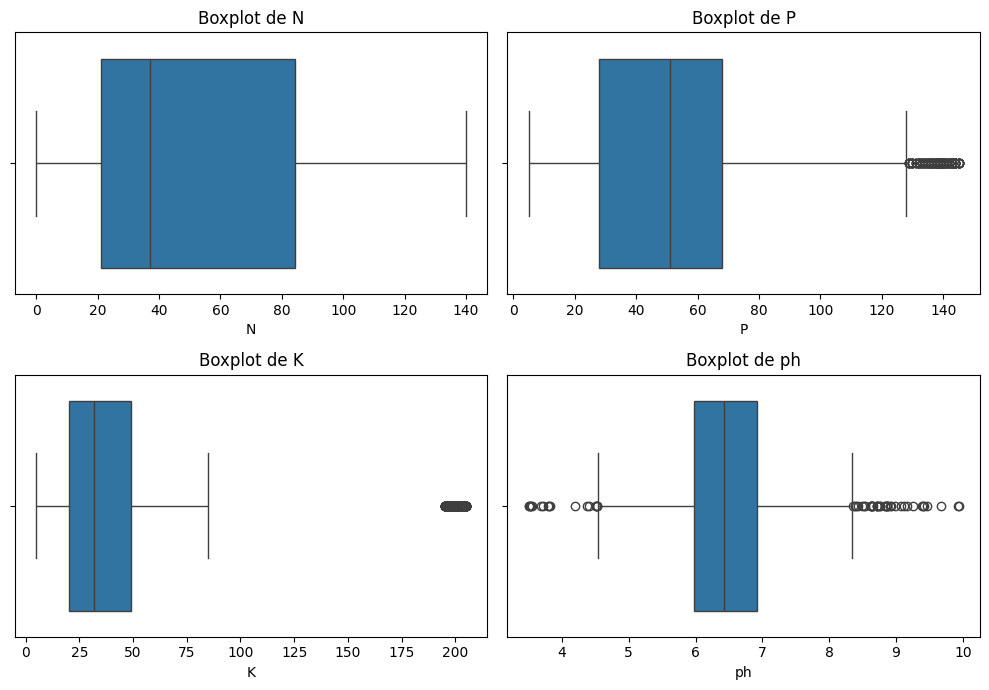

In [9]:
#Observamos diagrama de cajas para ver los valores atipicos

data_graf = data[['N', 'P', 'K', 'ph']]
fig, axes = plt.subplots(2, 2, figsize=(10, 7))
axes = axes.flatten()

for i,col in enumerate(data_graf.columns):
  sns.boxplot(data =data, x =col, ax=axes[i])
  axes[i].set_title(f'Boxplot de {col}')
  axes[i].set_xlabel(col)

plt.tight_layout()
plt.show()

In [10]:
print(data['crop'].value_counts())

print(f"\nCatidad de distintos valores: {data['crop'].nunique()}")

crop
rice           100
maize          100
jute           100
cotton         100
coconut        100
papaya         100
orange         100
apple          100
muskmelon      100
watermelon     100
grapes         100
mango          100
banana         100
pomegranate    100
lentil         100
blackgram      100
mungbean       100
mothbeans      100
pigeonpeas     100
kidneybeans    100
chickpea       100
coffee         100
Name: count, dtype: int64

Catidad de distintos valores: 22


Las variables N, P, K, pH tienen distribuciones con asimetría y valores atípicos, pero eso se considera normal dado que hay 22 clases (cultivos).

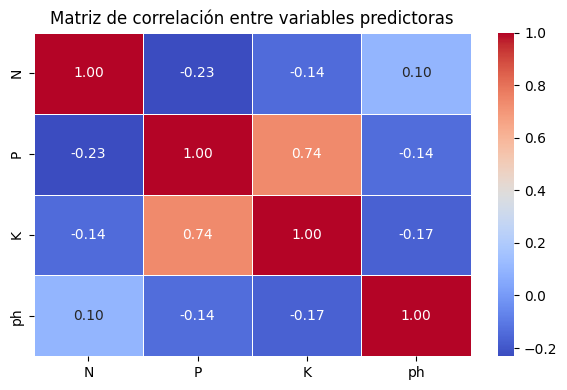

In [11]:
# Mapa de calor solo las variables predictoras
features = data[['N', 'P', 'K', 'ph']]

# Calcular la matriz de correlación
corr_matrix = features.corr()

# Crear el heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Matriz de correlación entre variables predictoras")
plt.tight_layout()
plt.show()

El mapa de calor muestra baja correlación entre variables predictoras, por lo que no hay colinealidad que justifique eliminar ninguna.

## Preprocesamiento

In [12]:
# Copiamos el dataframe original para no modeificar los datos originales
data1 = data.copy()

In [13]:
#Transformamos la variable objetivo con labelencoder pues debemos tener una variable objetivo numerica.

x = data1[['N','P','K','ph']]
y = LabelEncoder().fit_transform(data1['crop'])

x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)

In [14]:
pt = PowerTransformer(method='yeo-johnson')
x_train = pd.DataFrame(pt.fit_transform(x_train), columns=x_train.columns, index=x_train.index)
x_test = pd.DataFrame(pt.transform(x_test), columns=x_test.columns, index=x_test.index)

Se aplicó LabelEncoder a la variable objetivo, necesaria para los modelos de clasificación.

Se usó PowerTransformer (Yeo-Johnson) para mejorar la distribución de los predictores, reduciendo el efecto de outliers y favoreciendo modelos lineales.

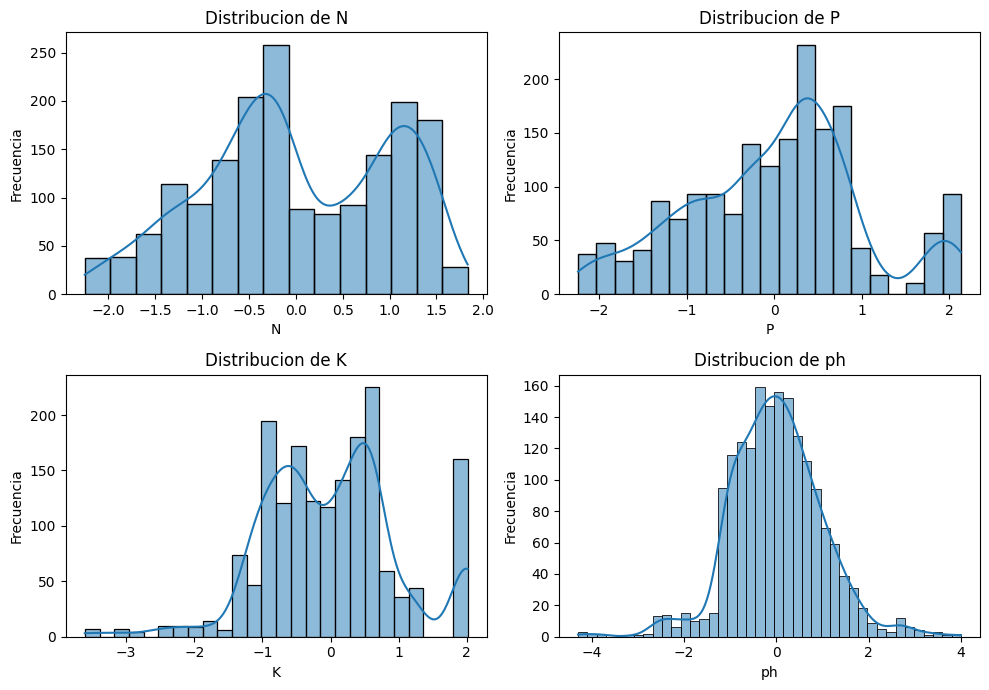

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(10, 7))
axes = axes.flatten()

for i,col in enumerate(x_train.columns):
  sns.histplot(data =x_train, x =col, kde=True, ax=axes[i])
  axes[i].set_title(f'Distribucion de {col}')
  axes[i].set_xlabel(col)
  axes[i].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

Aqui verificamos que la distribucion se acerca mas a una distribucion normal.

In [16]:
# Escalamos los datos numericos
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

##Modelacion

In [17]:
#Modelamos por regresion Logistica
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500)
model.fit(x_train_scaled, y_train)
y_pred = model.predict(x_test_scaled)

print(f"f1 regresion logistica: {f1_score(y_test, y_pred, average='weighted'):.2f}")
print(f"Exactitud: {accuracy_score(y_test, y_pred):.2f}")


f1 regresion logistica: 0.68
Exactitud: 0.68


c:\Users\juan6\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [18]:
#Modelamos por bosque aleatorio
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, classification_report

# Modelo
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf_model.fit(x_train_scaled, y_train)

# Predicciones
y_pred_rf = rf_model.predict(x_test_scaled)

# Métricas
print(f"Random Forest - F1 Weighted: {f1_score(y_test, y_pred_rf, average='weighted'):.2f}")
print(f"Random Forest - Exactitud: {accuracy_score(y_test, y_pred_rf):.2f}")


Random Forest - F1 Weighted: 0.78
Random Forest - Exactitud: 0.78


In [19]:
#Modelamos por Catboost
cat_model = CatBoostClassifier(
    iterations=100,              # Número de árboles (similar a n_estimators)
    learning_rate=0.05,           # Tasa de aprendizaje
    depth=5,                     # Profundidad de los árboles
    loss_function='MultiClass',  # Para clasificación multiclase
    eval_metric='MultiClass',    # Métrica para monitorizar durante el entrenamiento
    random_seed=42,              # Para reproducibilidad
    verbose=0                    # Suprime la salida de entrenamiento, pon 10 para ver cada 10 iteraciones
)

cat_model.fit(x_train_scaled, y_train) # Asumiendo que x_train_scaled y y_train están definidos

# Predicciones
y_pred_cat = cat_model.predict(x_test_scaled)
y_pred_cat_flat = y_pred_cat.flatten()

# Métricas (estas siguen siendo de scikit-learn y requieren average='weighted')
print(f"CatBoost - F1 Weighted: {f1_score(y_test, y_pred_cat_flat, average='weighted'):.2f}")
print(f"CatBoost - Accuracy: {accuracy_score(y_test, y_pred_cat_flat):.2f}")
print("\nClassification Report (CatBoost):\n", classification_report(y_test, y_pred_cat_flat))

CatBoost - F1 Weighted: 0.78
CatBoost - Accuracy: 0.79

Classification Report (CatBoost):
               precision    recall  f1-score   support

           0       0.58      0.70      0.64        20
           1       1.00      1.00      1.00        20
           2       0.87      0.65      0.74        20
           3       1.00      1.00      1.00        20
           4       0.71      1.00      0.83        20
           5       1.00      1.00      1.00        20
           6       0.95      1.00      0.98        20
           7       0.62      0.50      0.56        20
           8       0.58      0.70      0.64        20
           9       0.74      1.00      0.85        20
          10       0.56      0.75      0.64        20
          11       1.00      0.95      0.97        20
          12       1.00      0.65      0.79        20
          13       0.94      0.80      0.86        20
          14       0.80      1.00      0.89        20
          15       0.45      0.45      0.45 

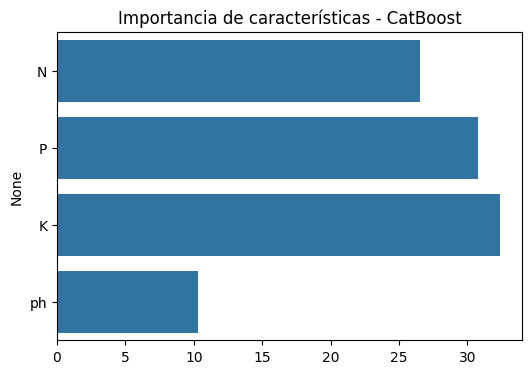

In [20]:
import matplotlib.pyplot as plt

feature_importances = cat_model.get_feature_importance()
features = x.columns

plt.figure(figsize=(6, 4))
sns.barplot(x=feature_importances, y=features)
plt.title('Importancia de características - CatBoost')
plt.show()


## Conclusiones


✅ CatBoost es el modelo más robusto para este problema de clasificación multiclase. Su capacidad para manejar relaciones no lineales y tratar internamente variables numéricas y categóricas lo hacen ideal.

⚠️ Regresión Logística tuvo el peor desempeño, lo que sugiere que no hay una separación lineal clara entre las clases. Aun así, fue útil como baseline.

✅ El uso de PowerTransformer y StandardScaler fue acertado para corregir distribuciones y normalizar los datos, lo que ayuda especialmente en modelos lineales.

🧪 El modelo puede ayudar a reducir costos de análisis de suelo, ya que predice el cultivo óptimo sin necesidad de medir más de estas 4 características.

✅ El modelo CatBoost considera que el nivel de Potasio (K) es la variable más crítica para determinar qué cultivo sembrar, seguido por el Fósforo (P) y el Nitrógeno (N). El pH tiene una influencia mucho menor.